# Lab09-3

Model Application (garlic)

In [1]:
using Cropbox

In [2]:
using Cropbox.TimeZones

## Garlic Model

In this notebook, we're taking a brief look at a [garlic model](https://doi.org/10.1093/aob/mcz060). The model was originally written in C++ and later reimplemented in Julia as a testbed for developing Cropbox framework. The model is quite complex that the coupled gas-exchange model is just a small component in this model. Yet, the structure of the model must be not too unfamiliar since the most parts of underlying concepts (*i.e.* leaf growth, phenology, carbon allocation) have been covered during the class in a way. Feel free to take a look at the source code in `L09_Model_Synthesis/garlic` directory.

In [3]:
include("garlic/garlic.jl")

Main.Garlic

### Configurations

The original model was developed with two years of measurements data for two cultivars named KM (Korean Mountain) and SP (Shantang Purple) with two separate planting dates. In addition, scape was optionally removed. There are some parameters shared between combinations, yet some are specific to each treatment (*i.e.* cultivar). Let's build pieces of configuration.

#### Cultivars

In [4]:
KMSP = (
# # CV PHYL ILN GLN LL LER SG SD LTAR LTARa LIR Topt Tceil critPPD
# KM1 134 4 10 65.0 4.70 1.84 122 0 0.4421 0.1003 22.28 34.23 12
    :Phenology => (
        optimal_temperature = 22.28, # Topt
        ceiling_temperature = 34.23, # Tceil
        maximum_germination_rate = 0.45,
        maximum_emergence_rate = 0.2,
        critical_photoperiod = 12, # critPPD
        #initial_leaves_at_harvest = , # ILN
        maximum_leaf_initiation_rate = 0.1003, # LIR
        # storage_days = 100, # SD
        storage_temperature = 5,
        # maximum_leaf_tip_appearance_rate = 0, # LTAR (tracked)
        maximum_leaf_tip_appearance_rate_asymptote = 0.4421, # LTARa
        leaves_generic = 10, # GLN
    ),
    :Leaf => (
        maximum_elongation_rate = 4.70, # LER
        minimum_length_of_longest_leaf = 65.0, # LL
        # stay_green = , # SG
    ),
    :Carbon => (
# # Rm Yg
# 0.012 0.8
        maintenance_respiration_coefficient = 0.012, # Rm
        synthesis_efficiency = 0.8, # Yg
        partitioning_table = [
        # root shoot leaf sheath scape bulb
          0.00  0.00 0.00   0.00  0.00 0.00 ; # seed
          0.10  0.00 0.45   0.45  0.00 0.00 ; # vegetative
          0.10  0.00 0.15   0.25  0.10 0.40 ; # bulb growth with scape
          0.10  0.00 0.15   0.30  0.00 0.45 ; # bulb growth without scape
          0.00  0.00 0.00   0.00  0.00 0.00 ; # dead
        ],
    ),
);

In [5]:
KM = (KMSP, (
    :Phenology => (initial_leaves_at_harvest = 4,), # ILN
    :Leaf => (stay_green = 1.84,), # SG
));

In [6]:
SP = (KMSP, (
    :Phenology => (initial_leaves_at_harvest = 6,), # ILN
    :Leaf => (stay_green = 1.47,), # SG
));

#### Location

In [7]:
CUH = (
# # LAT LONG ALT
# 47.66 122.29 20.0
    :Location => (
        latitude = 47.66, # LAT
        longitude = 122.29, #LONG
        altitude = 20.0, # ALT
    ),
# # CO2 timestep
# 390 60
    :Weather => (
        CO2 = 390, # CO2
    ),
    :Plant => (planting_density = 55,), # PD
);

#### Years

In [8]:
CUH_2013 = (CUH, (
    :Weather => (
        filename = "garlic/data/CUH/2013.wea", # .dat
        timezone = tz"America/Los_Angeles",
    ),
    :Calendar => (
        init = ZonedDateTime(2013, 10, 30, tz"America/Los_Angeles"), # Y1 bgn
        last = ZonedDateTime(2014, 7, 28, tz"America/Los_Angeles"), #Y2 end
    ),
));

In [9]:
CUH_2014 = (CUH, (
    :Weather => (
        filename = "garlic/data/CUH/2014.wea", # .dat
        timezone = tz"America/Los_Angeles",
    ),
    :Calendar => (
        # 2014.wea starts from 2014-09-01 01:00, not 00:00
        init = ZonedDateTime(2014, 9, 1, 1, tz"America/Los_Angeles"), # Y1 bgn
        last = ZonedDateTime(2015, 7, 7, tz"America/Los_Angeles"), #Y2 end
    ),
));

#### Planting Dates

In [10]:
CUH_2013_P1 = (CUH_2013, (
    :Phenology => (
        storage_days = 122, # SD
        planting_date = ZonedDateTime(2013, 10, 30, tz"America/Los_Angeles"), # Y1 sow
    ),
));
CUH_2013_P2 = (CUH_2013, (
    :Phenology => (
        storage_days = 170, # SD
        planting_date = ZonedDateTime(2013, 12, 17, tz"America/Los_Angeles"), # Y1 sow
    ),
));
CUH_2014_P1 = (CUH_2014, (
    :Phenology => (
        storage_days = 93, # SD
        planting_date = ZonedDateTime(2014, 10, 1, tz"America/Los_Angeles"), # Y1 sow
    ),
));
CUH_2014_P2 = (CUH_2014, (
    :Phenology => (
        storage_days = 143, # SD
        planting_date = ZonedDateTime(2014, 11, 20, tz"America/Los_Angeles"), # Y1 sow
    ),
));

#### Scape Removal

In [11]:
KM_2013_P1_SR0 = (KM, CUH_2013_P1, (
    :Phenology => (
        emergence_date = ZonedDateTime(2013, 12, 29, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));
KM_2013_P2_SR0 = (KM, CUH_2013_P2, (
    :Phenology => (
        emergence_date = ZonedDateTime(2014, 1, 26, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));
KM_2014_P1_SR0 = (KM, CUH_2014_P1, (
    :Phenology => (
        emergence_date = ZonedDateTime(2014, 10, 26, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));
KM_2014_P2_SR0 = (KM, CUH_2014_P2, (
    :Phenology => (
        emergence_date = ZonedDateTime(2014, 12, 30, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));

In [12]:
SP_2013_P1_SR0 = (SP, CUH_2013_P1, (
    :Phenology => (
        emergence_date = ZonedDateTime(2013, 11, 14, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));
SP_2013_P2_SR0 = (SP, CUH_2013_P2, (
    :Phenology => (
        emergence_date = ZonedDateTime(2014, 1, 6, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));
SP_2014_P1_SR0 = (SP, CUH_2014_P1, (
    :Phenology => (
        emergence_date = ZonedDateTime(2014, 10, 6, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));
SP_2014_P2_SR0 = (SP, CUH_2014_P2, (
    :Phenology => (
        emergence_date = ZonedDateTime(2014, 11, 30, tz"America/Los_Angeles"), # Y1 emg
        scape_removal_date = nothing, # Y2 SR
    ),
));

## Simulation

In [13]:
r = simulate(Garlic.Model;
    config = KM_2014_P2_SR0,
    stop = "calendar.count",
    snap = 1u"d",
)

Progress: 100%[=========================================] Time: 0:00:37:09


,tick,initial_leaf_ratio,potential_leaf_area_increase,shoot_carbon,root_carbon
,Quantit…,Float64,Quantit…,Quantit…,Quantit…
1,0.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
2,24.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
3,48.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
4,72.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
5,96.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
6,120.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
7,144.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
8,168.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1
9,192.0 hr,0.126,0.0 cm^2,0.0 g d^-1,0.0 g d^-1


### Leaf Development

Replicating Fig. 3.D.

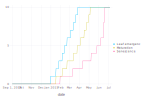

In [14]:
plot(r, :date, [:leaves_appeared, :leaves_mature, :leaves_dropped];
    names = ["Leaf emergence", "Maturation", "Senescence"],
    kind = :line,
)

### Leaf Area Expansion

Replicating Fig. 4.D.

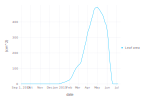

In [15]:
plot(r, :date, :green_leaf_area;
    name = "Leaf area",
    kind = :line,
)

### Biomass Allocation

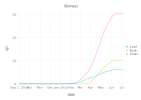

In [16]:
plot(r, :date, [:leaf_mass, :bulb_mass, :total_mass];
    title = "Biomass",
    names = ["Leaf", "Bulb", "Total"],
    kind = :line,
)